In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import pathlib
import glob
import cv2
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
PATH_TO_LABELS = 'data/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


# For the sake of simplicity we will test on 2 images:

# In[ ]:


# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
# PATH_TO_TEST_IMAGES_DIR = pathlib.Path('images/test')
# TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.png")))
TEST_IMAGE_PATHS = glob.glob('images/test/*.png')
print(TEST_IMAGE_PATHS)
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[0:5]


# # Detection

# Load an object detection model:
MODEL_NAME = 'trained'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/labelmap.pbtxt'

NUM_CLASSES = 1

['images/test\\00006697_005.png', 'images/test\\00006699_007.png', 'images/test\\00006699_016.png', 'images/test\\00006700_005.png', 'images/test\\00006706_002.png', 'images/test\\00006712_000.png', 'images/test\\00006713_002.png', 'images/test\\00006717_003.png', 'images/test\\00006720_008.png', 'images/test\\00006720_011.png', 'images/test\\00006720_014.png', 'images/test\\00006736_002.png', 'images/test\\00006738_000.png', 'images/test\\00006739_002.png', 'images/test\\00006739_005.png', 'images/test\\00006741_009.png', 'images/test\\00006767_000.png', 'images/test\\00006769_022.png', 'images/test\\00006775_002.png', 'images/test\\00006783_003.png', 'images/test\\00006790_001.png', 'images/test\\00006791_003.png', 'images/test\\00006808_006.png', 'images/test\\00006811_001.png', 'images/test\\00006815_000.png', 'images/test\\00006816_002.png', 'images/test\\00006819_000.png', 'images/test\\00006821_004.png', 'images/test\\00006827_006.png', 'images/test\\00006832_002.png', 'images/t

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [4]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]

    return output_dict

In [8]:
def show_inference(model, image_path):
    
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  # image_np = np.array(Image.open(image_path))
    image_np=cv2.imread(image_path)
    (w,h,c) = image_np.shape
    print("::::::: {}:{} ".format(w,h))
    print(type(image_np))
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np,model)
  # Visualization of the results of a detection.
  
        
    vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks_reframed', None),
              use_normalized_coordinates=True,
              line_thickness=8,
                min_score_thresh=0.52)
    display(Image.fromarray(image_np))
    
    boxes = output_dict['detection_boxes']
    # get all boxes from an array
    max_boxes_to_draw = boxes.shape[0]
    # get scores to get a threshold
    scores = output_dict['detection_scores']
    # this is set as a default but feel free to adjust it to your needs
    min_score_thresh=.5
    # iterate over all objects found
    
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        # 
        if scores is None or scores[i] > min_score_thresh:
            # boxes[i] is the box which will be drawn
            class_name = category_index[output_dict['detection_classes'][i]]['name']
            print ("This box is gonna get used", boxes[i], output_dict['detection_classes'][i], output_dict['detection_scores'][i])

::::::: 1024:1024 
<class 'numpy.ndarray'>


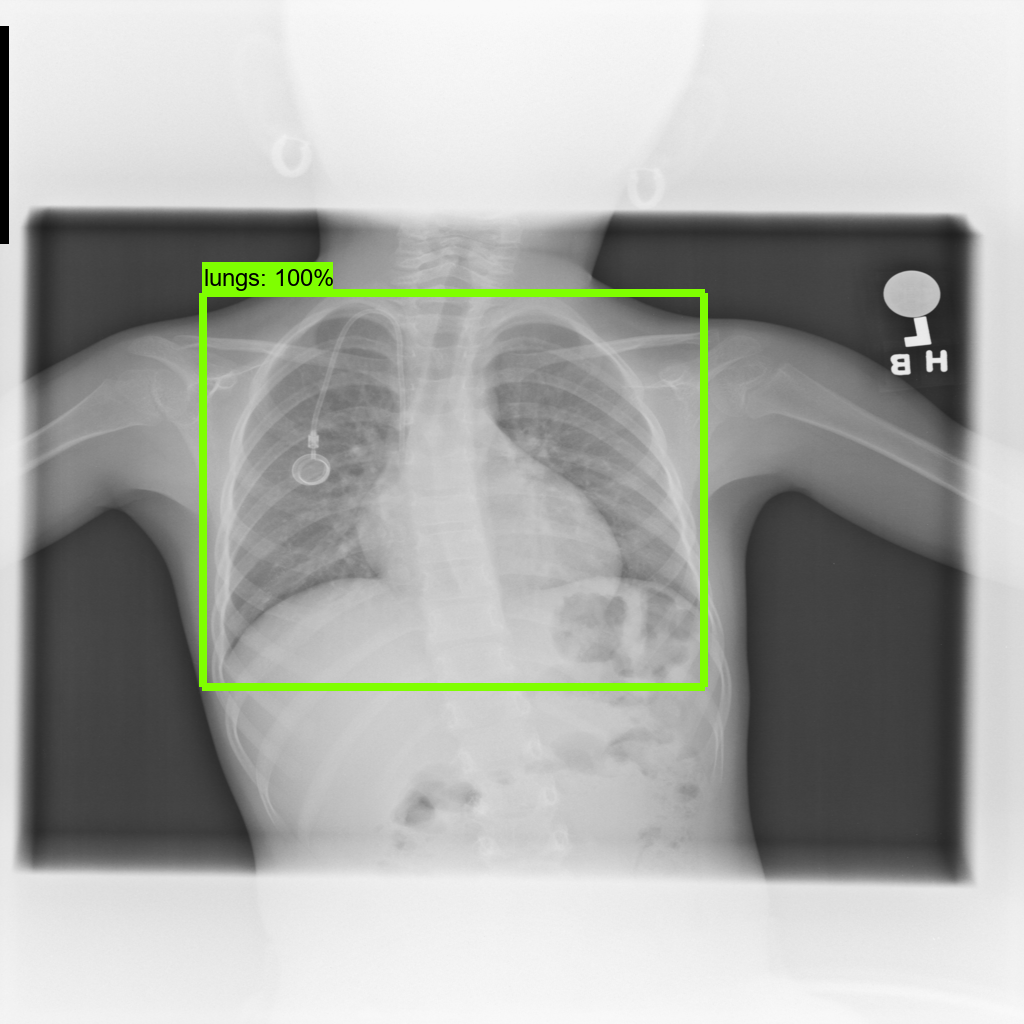

This box is gonna get used [0.28657493 0.19766846 0.67081416 0.6880655 ] 1 1.0


In [9]:
show_inference(detection_graph, 'images/test/00006843_000.png')

::::::: 1024:1024 
<class 'numpy.ndarray'>


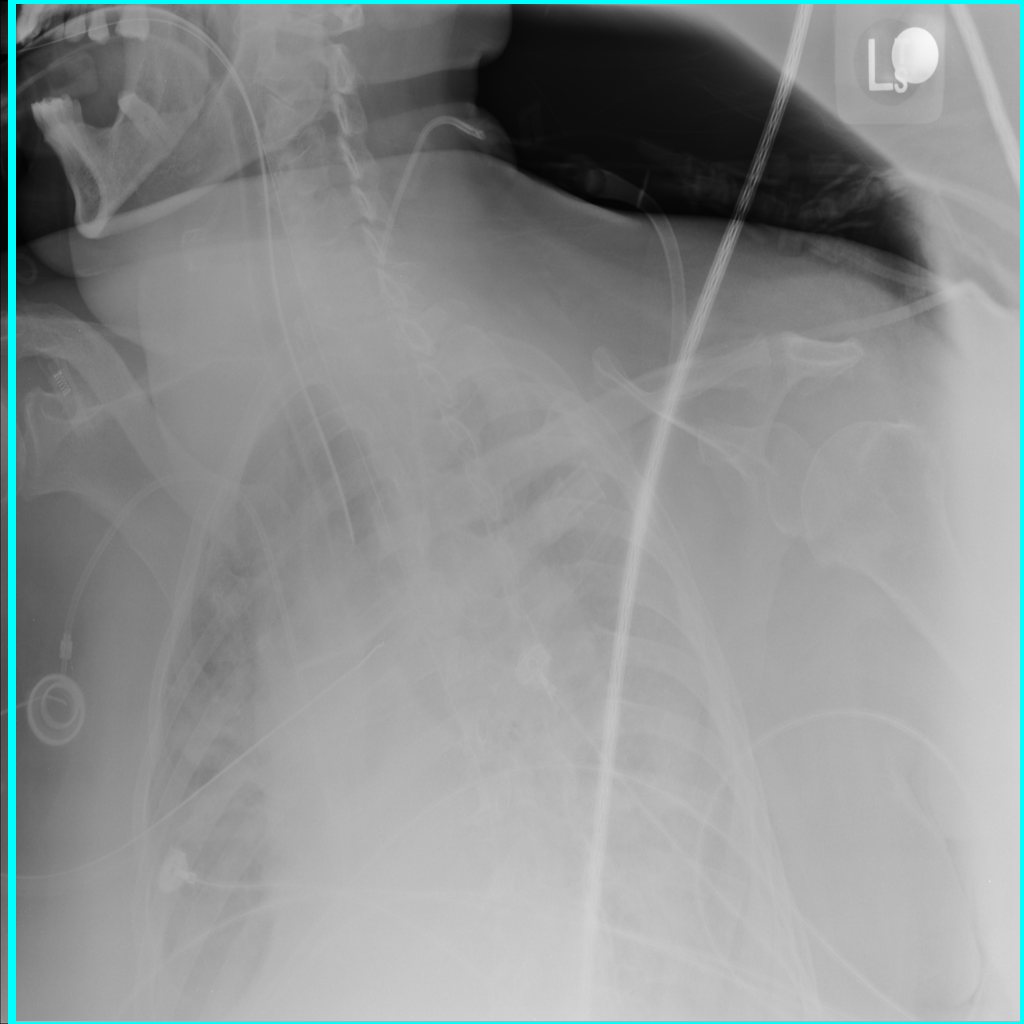

This box is gonna get used [0.         0.01167428 1.         1.        ] 2


In [7]:

show_inference(detection_graph, 'images/test/00007322_009.png')

In [12]:
def get_inference_info(image_path):
    image_np=cv2.imread(image_path)
    (w,h,c) = image_np.shape
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np,detection_graph)
    boxes = output_dict['detection_boxes']
    # get all boxes from an array
    max_boxes_to_draw = boxes.shape[0]
    # get scores to get a threshold
    scores = output_dict['detection_scores']
    # this is set as a default but feel free to adjust it to your needs
    min_score_thresh=.5
    # iterate over all objects found
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        # 
        if scores is None or scores[i] > min_score_thresh:
            # boxes[i] is the box which will be drawn
            class_name = category_index[output_dict['detection_classes'][i]]['name']
            coordinates = boxes[i]
            coordinates[0] *= h
            coordinates[1] *= w
            coordinates[2] *= h
            coordinates[3] *= w
    return (coordinates, output_dict['detection_classes'][0], output_dict['detection_scores'][0], w, h)
    #crop_img = image_np[int(coordinates[0]):int(coordinates[2]), int(coordinates[1]):int(coordinates[3])]
    #display(Image.fromarray(crop_img))

In [22]:
def crop_and_resize(input_path,output_path,width,height):
    info = crop_and_resize_image(input_path)
    image_np=cv2.imread(input_path)
    crop_img = image_np[int(info[0][0]):int(info[0][2]), int(info[0][1]):int(info[0][3])]
    output = cv2.resize(crop_img, (width,height))
    cv2.imwrite(output_path,output) 

In [23]:
crop_and_resize('images/test/00006843_000.png','images/output/00006843_000.png',1024,1024)